this was first attempt at using svc, it works but this did not include tuning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score

In [2]:
data = pd.read_csv('../data/processed/aggregated_dataset.csv')
print("Dataset shape:", data.shape)
data.head()

Dataset shape: (40798, 1029)


,NLOS,RANGE,FP_IDX,FP_AMP1,FP_AMP2,FP_AMP3,STDEV_NOISE,CIR_PWR,MAX_NOISE,RXPACC,...,CIR1009,CIR1010,CIR1011,CIR1012,CIR1013,CIR1014,CIR1015,CIR_MEAN,CIR_MAX,CIR_MIN
0,0.0,3.90,745.0,18712.0,10250.0,11576.0,64.0,11855.0,967.0,611.0,...,158.0,198.0,87.0,296.0,505.0,307.0,0.0,395.225394,23077.0,0.0
1,0.0,0.66,749.0,11239.0,6313.0,4712.0,64.0,18968.0,1133.0,447.0,...,228.0,187.0,213.0,202.0,89.0,103.0,0.0,444.060039,18059.0,0.0
2,1.0,7.86,746.0,4355.0,5240.0,3478.0,60.0,14699.0,894.0,723.0,...,174.0,124.0,329.0,207.0,96.0,218.0,0.0,503.485236,16809.0,0.0
3,1.0,3.48,750.0,8502.0,8416.0,5890.0,76.0,8748.0,1127.0,1024.0,...,160.0,434.0,397.0,290.0,155.0,342.0,256.0,413.054134,15742.0,13.0
4,0.0,1.19,746.0,17845.0,18095.0,12058.0,68.0,11380.0,1744.0,276.0,...,296.0,87.0,178.0,314.0,247.0,292.0,256.0,363.357283,19583.0,1.0


In [3]:
# Features and labels
X = data.drop(columns=['NLOS', 'RANGE'])
y_class = data['NLOS']  # Classification labels
y_reg = data['RANGE']   # Regression labels

In [4]:
# Split for classification (stratified split)
X_train, X_test, y_class_train, y_class_test = train_test_split(
    X, y_class, test_size=0.3, stratify=y_class, random_state=42
)

# Split for regression (same indices)
_, _, y_reg_train, y_reg_test = train_test_split(
    X, y_reg, test_size=0.3, random_state=42
)

In [5]:
# Step 5: Feature Scaling (Critical for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# ## Step 6: Train SVM Classifier (LOS/NLOS)
# Initialize SVM classifier
svm_classifier = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=42
)

# Train the model
svm_classifier.fit(X_train_scaled, y_class_train)

SVC(random_state=42)

Classification Accuracy: 0.87
              precision    recall  f1-score   support

         0.0       0.83      0.92      0.87      6216
         1.0       0.91      0.81      0.86      6024

    accuracy                           0.87     12240
   macro avg       0.87      0.86      0.86     12240
weighted avg       0.87      0.87      0.86     12240



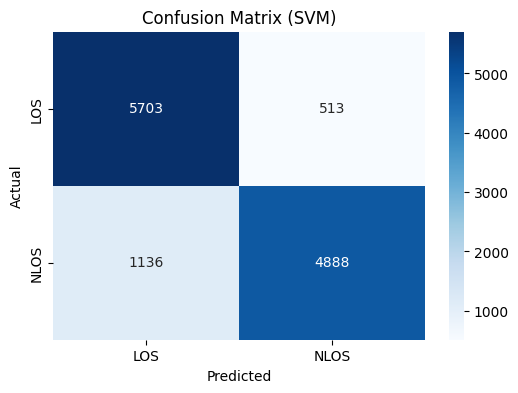

In [7]:
# Predict and evaluate
y_class_pred = svm_classifier.predict(X_test_scaled)
print(f"Classification Accuracy: {accuracy_score(y_class_test, y_class_pred):.2f}")
print(classification_report(y_class_test, y_class_pred))

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_class_test, y_class_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=['LOS', 'NLOS'], yticklabels=['LOS', 'NLOS'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (SVM)')
plt.show()

RMSE: 2.41
R² Score: -0.05


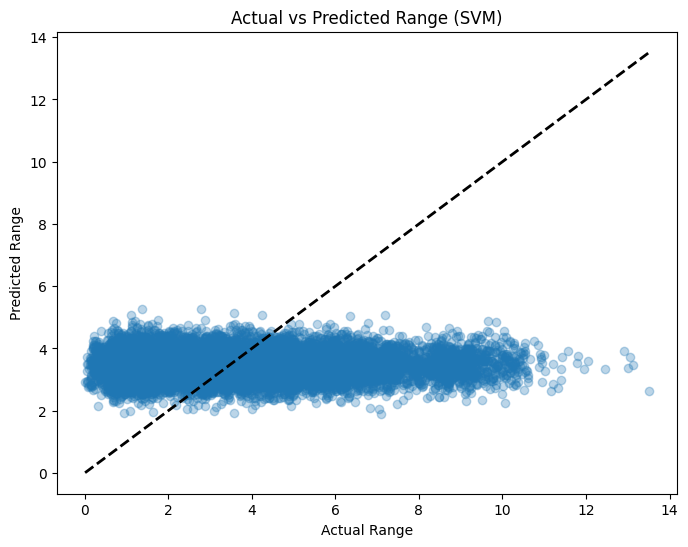

In [8]:
# ## Step 7: Train SVM Regressor (Range Prediction)
# %%
# Initialize SVM regressor
svm_regressor = SVR(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    epsilon=0.1
)

# Train the model
svm_regressor.fit(X_train_scaled, y_reg_train)

# Predict and evaluate
y_reg_pred = svm_regressor.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred))
r2 = r2_score(y_reg_test, y_reg_pred)
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_reg_test, y_reg_pred, alpha=0.3)
plt.plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'k--', lw=2)
plt.xlabel('Actual Range')
plt.ylabel('Predicted Range')
plt.title('Actual vs Predicted Range (SVM)')
plt.show()